In [8]:
import os
import glob
import numpy as np
import rasterio
import pandas as pd
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [9]:
# --- CONFIGURATION ---
ROOT_DIR = '/Users/ruben/Desktop/Thesis/TrainingData/VIIRS-PhilSA-50Sample'  # VIIRS folder
IMG_SIZE = 32          # Standard image size (if chips vary, we crop/resize)
NUM_CLASSES = 3        # Low, Moderate, High

In [10]:
# --- 1. LOAD DATA ---
X_images = [] # Input images
y_radiance = []  # Store raw radiance first to calculate quantiles later
cluster_tracker = []   # To remember which image belongs to which Cluster ID

# Find all cluster folders
cluster_folders = glob.glob(os.path.join(ROOT_DIR, 'VIIRS_PH2022*'))
print(f"Found {len(cluster_folders)} clusters. Loading monthly images...")

for folder in cluster_folders:
    folder_name = os.path.basename(folder)
    
    # Extract ID ignoring the prefix and padding zeros
    match = re.search(r'VIIRS_PH20220*(\d+)$', folder_name)
    
    if match:
        c_id = int(match.group(1))
    else:
        continue # Skip folders that don't match the pattern
    tif_files = glob.glob(os.path.join(folder, '*.tif'))
    
    for tif in tif_files:
        with rasterio.open(tif) as src:
            # 1. Read the raw data
            img = src.read(1)
            img = np.nan_to_num(img) # Replace NaNs with 0
            
            # 2. Add the "Channel" dimension (Height, Width, 1)
            # TensorFlow requires this extra dimension
            img_tensor = img.reshape(img.shape[0], img.shape[1], 1)
            
            # 3. Resize
            # This stretches Urban (9x9) and shrinks Rural (22x22) to exactly 32x32
            # method='bilinear' smooths the pixelation when sizing up
            img_resized = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE], method='bilinear')
            
            # 4. Store
            X_images.append(img_resized.numpy())
            y_radiance.append(np.mean(img)) # Store original mean for labeling
            cluster_tracker.append(c_id)

# Convert to Numpy Array
X = np.array(X_images)

print(f"Final Data Shape: {X.shape}") 
# Output will be (Total_Images, 32, 32, 1) - Perfect for CNN

Found 50 clusters. Loading monthly images...
Final Data Shape: (600, 32, 32, 1)


In [11]:
# --- 2. CREATE LABELS (QUANTILES) ---
# Determine thresholds for 3 balanced classes
df = pd.DataFrame({'radiance': y_radiance})
low_thresh = df['radiance'].quantile(0.33)
high_thresh = df['radiance'].quantile(0.66)

print(f"Thresholds -> Low: <{low_thresh:.2f}, High: >{high_thresh:.2f}")

def categorize(val):
    if val <= low_thresh: return 0      # Low
    elif val <= high_thresh: return 1   # Moderate
    else: return 2                      # High

# Apply categorization
y_labels = np.array([categorize(r) for r in y_radiance])
y_onehot = to_categorical(y_labels, num_classes=NUM_CLASSES)

# --- 3. NORMALIZE IMAGE DATA ---
# CNNs converge faster if inputs are 0-1
max_val = np.max(X)
X_norm = X / max_val

print(f"Data Shape: {X_norm.shape}")
print(f"Labels Shape: {y_onehot.shape}")

# Split Training (80%) and Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_onehot, test_size=0.2, random_state=42)

Thresholds -> Low: <0.34, High: >1.04
Data Shape: (600, 32, 32, 1)
Labels Shape: (600, 3)


In [14]:
from tensorflow.keras import layers, models, Input

def build_viirs_cnn(input_shape, num_classes):
    model = models.Sequential()
    
   # NEW WAY: Explicit Input Layer
    model.add(Input(shape=input_shape))
    
    # Now add your layers as normal (without input_shape argument)
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize with new size
model = build_viirs_cnn(input_shape=(32, 32, 1), num_classes=3)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,955 (23.26 KB)

 Trainable params: 5,955 (23.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4208 - loss: 1.0882 - val_accuracy: 0.6167 - val_loss: 1.0727
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6000 - loss: 1.0567 - val_accuracy: 0.6083 - val_loss: 1.0203
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6375 - loss: 0.9860 - val_accuracy: 0.6167 - val_loss: 0.9250
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6562 - loss: 0.8963 - val_accuracy: 0.6083 - val_loss: 0.8361
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6667 - loss: 0.8135 - val_accuracy: 0.6167 - val_loss: 0.7682
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6667 - loss: 0.7561 - val_accuracy: 0.6167 - val_loss: 0.7172
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6771 - loss: 0.7027 - val_accuracy: 0.6083 - val_loss: 0.6734
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6833 - loss: 0.6620 - val_accuracy: 0.6083 - val_loss

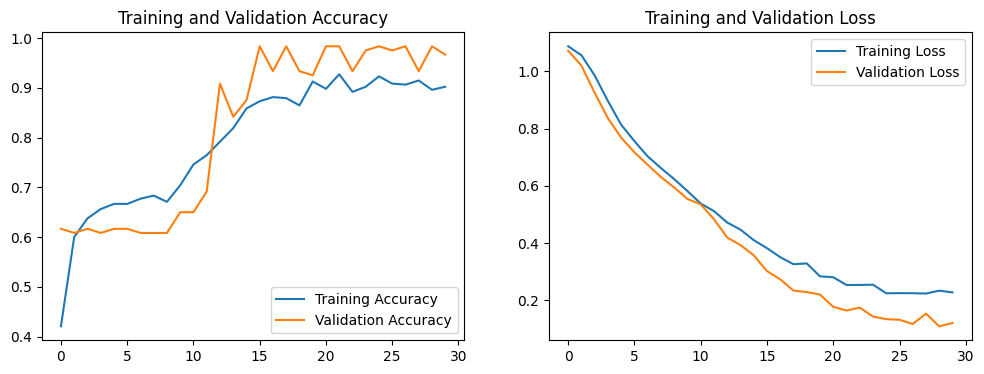


--- Sample Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image 1: True=Low, Pred=Low (91.7%)
Image 2: True=High, Pred=High (100.0%)
Image 3: True=Moderate, Pred=Moderate (59.6%)
Image 4: True=Moderate, Pred=Moderate (92.2%)
Image 5: True=High, Pred=High (100.0%)


In [15]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,             # Short training is usually enough for this simple task
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot Results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Final Test on a few images
print("\n--- Sample Predictions ---")
predictions = model.predict(X_val[:5])
classes = ['Low', 'Moderate', 'High']

for i in range(5):
    true_label = classes[np.argmax(y_val[i])]
    pred_label = classes[np.argmax(predictions[i])]
    confidence = np.max(predictions[i]) * 100
    print(f"Image {i+1}: True={true_label}, Pred={pred_label} ({confidence:.1f}%)")